<h1>Not Stop Recognizer - Neural Network & OpenCV</h1>

<h2>1. Modules</h2>

In [58]:
# for loading images 
import os, cv2 
import numpy as np 

# for preprocessing
from sklearn.model_selection import train_test_split

# for vizualization
import matplotlib.pyplot as plt

# for randomizing
from sklearn.utils import shuffle

# for neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from livelossplot import PlotLossesKeras

<h2>Load Images, resize the same, and assign the correspionded labels</h2>

In [7]:
# not_stop path images
not_stop_path = './not_stop/'

# stop path images
stop_path = './stop/'

# lists to hold images and labels
images = []
labels = []

# define the target size for resizing images
target_size = (128, 128)

# load not_stop images
for image_name in os.listdir(not_stop_path):
    image_path = os.path.join(not_stop_path, image_name)
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, target_size) # resize image
        images.append(image)
        labels.append(0) # label for not stop sign

# load stop images
for image_name in os.listdir(stop_path):
    image_path = os.path.join(stop_path, image_name)
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, target_size) # resize image
        images.append(image)
        labels.append(1) # label for not stop sign

<h2>View some images and their labels</h2>

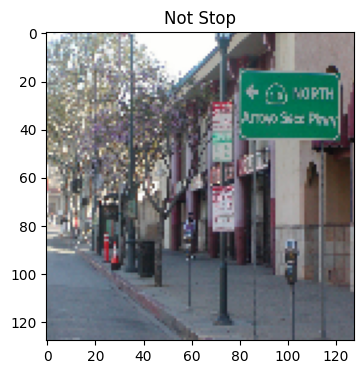

In [8]:
# first a not stop image
plt.figure(figsize = (10, 4))
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.title("Stop Sign" if labels[0] == 1 else "Not Stop")
plt.show()

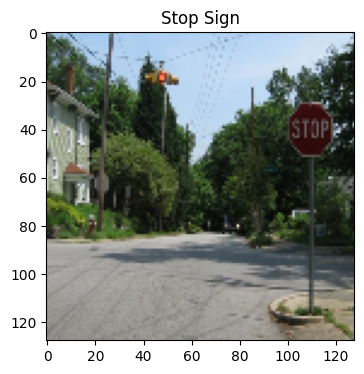

In [9]:
# second a stop image
plt.figure(figsize = (10, 4))
plt.imshow(cv2.cvtColor(images[100], cv2.COLOR_BGR2RGB))
plt.title("Stop Sign" if labels[100] == 1 else "Not Stop")
plt.show()

<h2>Shuffle the images and labels</h2>

In [10]:
# the images and labels are not shuffle at all, let's shuffle them
images, labels = shuffle(images, labels, random_state=42)

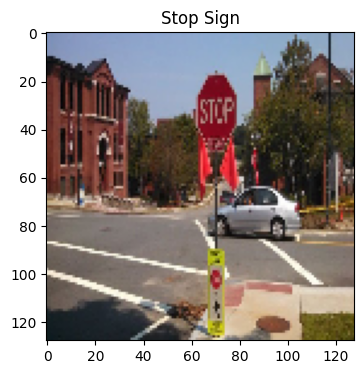

In [11]:
# view images and labels again

# a random image
plt.figure(figsize = (10, 4))
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.title("Stop Sign" if labels[0] == 1 else "Not Stop")
plt.show()

<h2>Preprocess images for training</h2>

In [13]:
# convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# normalize the images (pixel values between 0 and 1)
images_normalized = images / 255.0

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_normalized, labels, test_size=0.2, random_state=42)

<h2>Build, train and predict the model</h2>

In [133]:
# defining the CNN arhitecture with l2 regularization
model = Sequential([ # stacking the layers
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)), # convulational layer with 32 filters, each of size 3x3
    MaxPooling2D((2, 2)), # max pooling layer, reduce the dimensionality of features
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)), # convulational layer 64 filters, 3x3 size
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),


    Flatten(), # from 3D features to 1D
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)), # a fully connected layer with 128 units
    Dropout(0.4), # randmoly sets 30% of the input units to 0 at each update, prevents overfitting
    Dense(1, activation='sigmoid') # 0 and 1 for binary classification
])


In [134]:
# compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

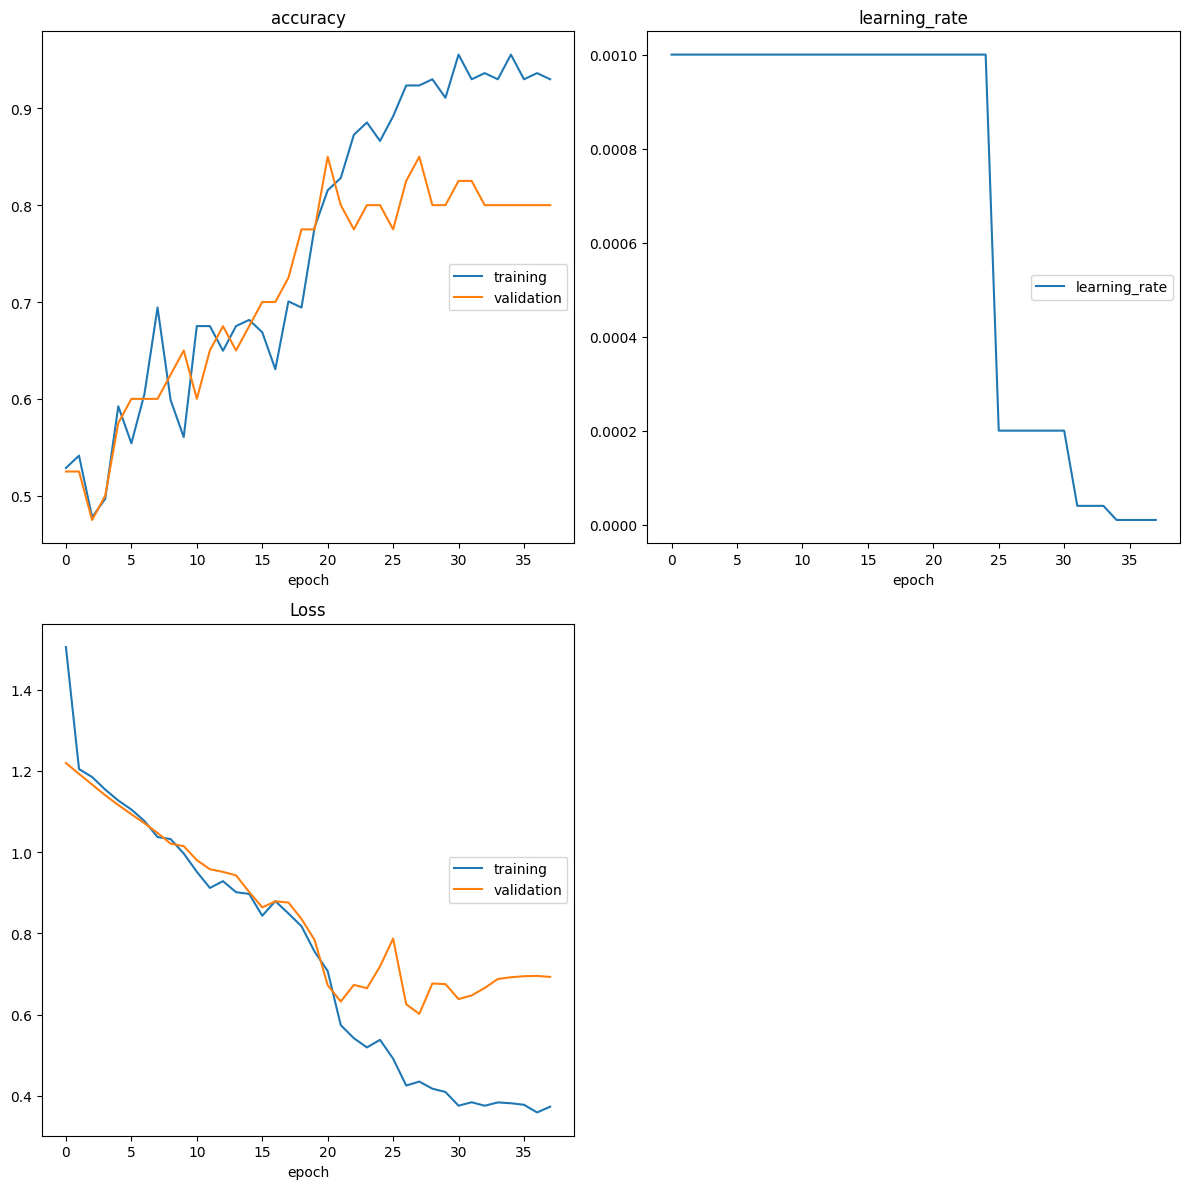

accuracy
	training         	 (min:    0.478, max:    0.955, cur:    0.930)
	validation       	 (min:    0.475, max:    0.850, cur:    0.800)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.001, cur:    0.000)
Loss
	training         	 (min:    0.359, max:    1.505, cur:    0.373)
	validation       	 (min:    0.602, max:    1.220, cur:    0.693)
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.9315 - loss: 0.3603 - val_accuracy: 0.8000 - val_loss: 0.6927 - learning_rate: 1.0000e-05


In [135]:
# callbacks
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.keras', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)


# model training

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpointer, early_stop, reduce_lr, PlotLossesKeras()]) # restore the best weights while monitoring the validation loss and stop training when the loss stop improving + learning rate dynamic)



In [137]:
# evaluate the model on the validation set

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8583 - loss: 0.5921
Validation accuracy: 0.8500000238418579


In [139]:
# make predictions on new data
predictions = model.predict(X_val)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to class labels

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


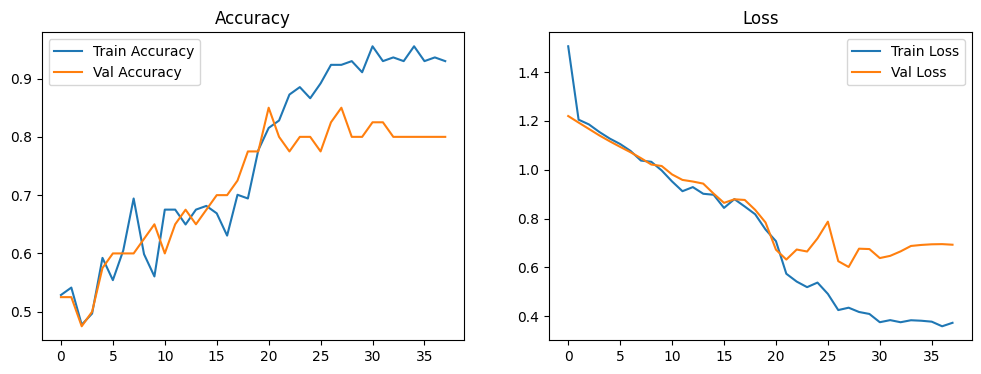

In [138]:
# plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()